In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
pip install pattern

In [2]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
stopwords = stopwords.words('english')

In [46]:
import pattern
from pattern.vector import count, LEMMA, Document, Model, KMEANS, HIERARCHICAL
from pattern.en import parse, suggest, Word, lemma, singularize, parse, tag, sentiment, mood, modality

In [50]:
data = pd.read_csv("./data/2024-09-10-abc-trump-harris-debate.csv")

In [51]:
harris_trump = data[14:][(data['speaker'] == "KAMALA HARRIS") | (data['speaker'] == "DONALD TRUMP")]
harris_trump.reset_index(inplace = True, names="id")
harris_trump.head()

<ipython-input-51-9c8177ed50d6>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  harris_trump = data[14:][(data['speaker'] == "KAMALA HARRIS") | (data['speaker'] == "DONALD TRUMP")]


,id,speaker,text
0,14,KAMALA HARRIS,"So, I was raised as a middle-class kid. And I ..."
1,16,DONALD TRUMP,"First of all, I have no sales tax. That's an i..."
2,18,KAMALA HARRIS,"Well, I would love to. Let's talk about what D..."
3,20,DONALD TRUMP,"Number one, I have nothing to do, as you know ..."
4,22,KAMALA HARRIS,"So, Donald Trump has no plan for you. And when..."


In [52]:
# remove rows whose text is less than 2 words or is a reaction to other candidate
short_idx = harris_trump['text'].apply(lambda x: 1 if (len(x.split(" ")) <= 2) | ("audible]" in x.split(" ")) else np.nan).dropna().index.to_list()
harris_trump.drop(short_idx, inplace = True)

In [53]:
journalists = data[13:][(data['speaker'] == "LINSEY DAVIS") | (data['speaker'] == 'DAVID MUIR')]
journalists[journalists['text'].str.contains("?", regex = False)]

<ipython-input-53-bb176f5bc4f8>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  journalists = data[13:][(data['speaker'] == "LINSEY DAVIS") | (data['speaker'] == 'DAVID MUIR')]


,speaker,text
13,DAVID MUIR,So let's get started. I want to begin tonight ...
26,DAVID MUIR,Vice President Harris I do want to ask for you...
30,DAVID MUIR,"President Trump, thank you. Linsey?"
31,LINSEY DAVIS,I want to turn to the issue of abortion. Presi...
41,LINSEY DAVIS,"Vice President Harris, I want to give you your..."
54,DAVID MUIR,We're going to turn now to immigration and bor...
58,DAVID MUIR,"Let me just ask, though, why did you try to ki..."
74,DAVID MUIR,You also said you would use local police. How ...
84,DAVID MUIR,"Vice President Harris, thank you. Linsey?"
87,DAVID MUIR,We have a lot to get to. Linsey?


In [54]:
topics = {"economy": [0, 29], 'abortion': [30, 52], 'immigration': [53, 75], 'crime': [76, 86], 'values': [87, 97], 'capitol attack': [98, 111], '2020 election': [112, 128], 'israel hamas war': [129, 139], 'russo ukrainian war': [140, 165], 'afghanistan': [166, 171], 'race': [172, 187], 'healthcare': [188, 197], 'climate change': [198, 204], 'closing statements': [205, 210]}

In [55]:
topics_idx = []
for topic, idx in topics.items():
  filtered = harris_trump[(harris_trump['id'] >= idx[0]) & (harris_trump['id'] <= idx[1])]
  for i in range(len(filtered)):
    topics_idx.append(topic)
harris_trump['topic'] = topics_idx
harris_trump.head()

,id,speaker,text,topic
0,14,KAMALA HARRIS,"So, I was raised as a middle-class kid. And I ...",economy
1,16,DONALD TRUMP,"First of all, I have no sales tax. That's an i...",economy
2,18,KAMALA HARRIS,"Well, I would love to. Let's talk about what D...",economy
3,20,DONALD TRUMP,"Number one, I have nothing to do, as you know ...",economy
4,22,KAMALA HARRIS,"So, Donald Trump has no plan for you. And when...",economy


In [56]:
new_rows = []

for i, row in harris_trump.iterrows():
    texts = row['text'].split(". ")

    if len(texts) > 1:
        harris_trump.at[i, 'text'] = texts[0]

        for t in texts[1:]:
            new_row = {
                'id': row['id'],
                'speaker': row['speaker'],
                'text': t,
                'topic': row['topic']
            }
            new_rows.append(new_row)

new_rows_df = pd.DataFrame(new_rows)

harris_trump = pd.concat([harris_trump, new_rows_df], ignore_index=True)

In [57]:
len(harris_trump)

1141

In [58]:
punctuations = ".,;:!?()[]{}`''\"@#$^&*+-|=~_"

In [60]:
# harris_trump['token'] = harris_trump['text'].apply(lambda x: [word.lower().strip() for (word, pos) in tag(x, tokenize=True, encoding='utf-8') if (pos not in [' ', '.', ',', '$', 'TO', 'WRB', 'PRP', 'IN', 'CC','PRP$']) & (word not in punctuations) & (word not in stopwords) & (word.isalpha())])
harris_trump['token'] = harris_trump['text'].apply(lambda x: [suggest(word.split("/")[-1])[0][0] for word in parse(x, lemmata = True).split(" ") if (word.split("/")[1] not in [' ', '.', ',', '$', 'TO', 'WRB', 'PRP', 'IN', 'CC','PRP$']) & (word.split("/")[1] not in punctuations) & (word.split("/")[1] not in stopwords) & (word.split("/")[1].isalpha())])
harris_trump.head()

,id,speaker,text,topic,token
0,14,KAMALA HARRIS,"So, I was raised as a middle-class kid",economy,"[so, be, raise, a, middle-class, kid]"
1,16,DONALD TRUMP,"First of all, I have no sales tax",economy,"[first, all, have, no, sale, tax]"
2,18,KAMALA HARRIS,"Well, I would love to",economy,"[well, would, love]"
3,20,DONALD TRUMP,"Number one, I have nothing to do, as you know ...",economy,"[number, one, have, nothing, do, know, know, b..."
4,22,KAMALA HARRIS,"So, Donald Trump has no plan for you",economy,"[so, donald, tramp, have, no, plan]"


In [61]:
# sentiment
harris_trump['polarity'] =  harris_trump['token'].apply(lambda x: sentiment(' '. join(x))[0])
harris_trump['subjectivity'] =  harris_trump['token'].apply(lambda x: sentiment(' '. join(x))[1])
harris_trump.head(5)

,id,speaker,text,topic,token,polarity,subjectivity
0,14,KAMALA HARRIS,"So, I was raised as a middle-class kid",economy,"[so, be, raise, a, middle-class, kid]",0.00,0.000000
1,16,DONALD TRUMP,"First of all, I have no sales tax",economy,"[first, all, have, no, sale, tax]",0.25,0.333333
2,18,KAMALA HARRIS,"Well, I would love to",economy,"[well, would, love]",0.50,0.600000
3,20,DONALD TRUMP,"Number one, I have nothing to do, as you know ...",economy,"[number, one, have, nothing, do, know, know, b...",0.50,0.500000
4,22,KAMALA HARRIS,"So, Donald Trump has no plan for you",economy,"[so, donald, tramp, have, no, plan]",0.00,0.000000


In [62]:
# certainty
harris_trump['certainty'] = harris_trump['token'].apply(lambda x: modality(' '. join(x)))
harris_trump.head(5)

,id,speaker,text,topic,token,polarity,subjectivity,certainty
0,14,KAMALA HARRIS,"So, I was raised as a middle-class kid",economy,"[so, be, raise, a, middle-class, kid]",0.00,0.000000,1.00
1,16,DONALD TRUMP,"First of all, I have no sales tax",economy,"[first, all, have, no, sale, tax]",0.25,0.333333,1.00
2,18,KAMALA HARRIS,"Well, I would love to",economy,"[well, would, love]",0.50,0.600000,-0.50
3,20,DONALD TRUMP,"Number one, I have nothing to do, as you know ...",economy,"[number, one, have, nothing, do, know, know, b...",0.50,0.500000,0.75
4,22,KAMALA HARRIS,"So, Donald Trump has no plan for you",economy,"[so, donald, tramp, have, no, plan]",0.00,0.000000,1.00


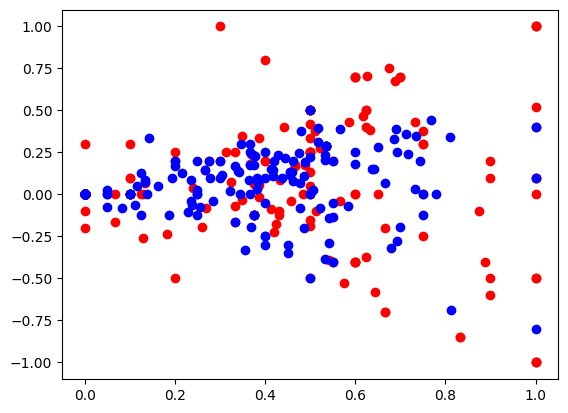

In [63]:
short_idx = harris_trump['token'].apply(lambda x: 1 if (len(x) <= 8) else np.nan).dropna().index.to_list()
plot = harris_trump.drop(short_idx)
plt.scatter(plot[plot['speaker'] == 'DONALD TRUMP']['subjectivity'], plot[plot['speaker'] == 'DONALD TRUMP']['polarity'], c = 'r')
plt.scatter(plot[plot['speaker'] == 'KAMALA HARRIS']['subjectivity'], plot[plot['speaker'] == 'KAMALA HARRIS']['polarity'], c = 'b')

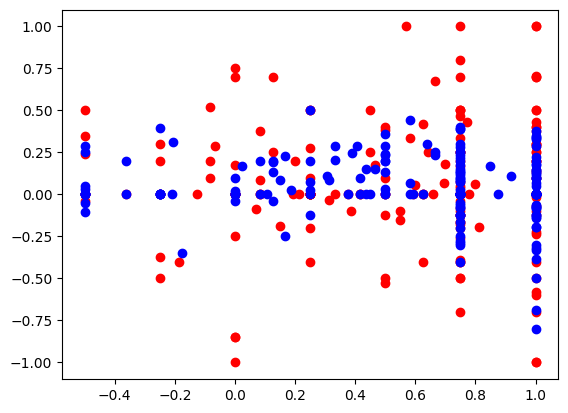

In [64]:
plt.scatter(plot[plot['speaker'] == 'DONALD TRUMP']['certainty'], plot[plot['speaker'] == 'DONALD TRUMP']['polarity'], c = 'r')
plt.scatter(plot[plot['speaker'] == 'KAMALA HARRIS']['certainty'], plot[plot['speaker'] == 'KAMALA HARRIS']['polarity'], c = 'b')

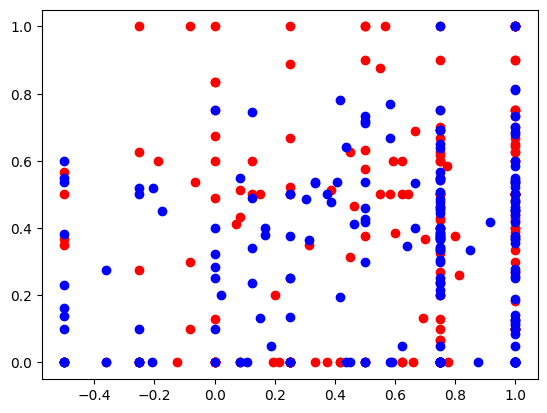

In [65]:
plt.scatter(plot[plot['speaker'] == 'DONALD TRUMP']['certainty'], plot[plot['speaker'] == 'DONALD TRUMP']['subjectivity'], c = 'r')
plt.scatter(plot[plot['speaker'] == 'KAMALA HARRIS']['certainty'], plot[plot['speaker'] == 'KAMALA HARRIS']['subjectivity'], c = 'b')

In [66]:
harris_trump.to_csv('./data/harris_trump.csv')

In [67]:
filler_words = ["γçô", "um", "uh", "ah", "er", "okay", "so", "like", "cool", "basically", "actually", "yeah"]

In [74]:
word_data = {}

In [75]:
keys = ["default"] + list(topics.keys())

for topic in keys:
  if (topic == "default"):
    filtered = harris_trump
  else:
    filtered = harris_trump[harris_trump['topic'] == topic]

  trump_filtered = filtered[filtered['speaker'] == 'DONALD TRUMP']
  harris_filtered = filtered[filtered['speaker'] == 'KAMALA HARRIS']

  trump_tokens = []
  for x in trump_filtered['token']:
    trump_tokens.extend(x)
  harris_tokens = []
  for x in harris_filtered['token']:
    harris_tokens.extend(x)

  trump_counts = count(trump_tokens)
  harris_counts = count(harris_tokens)

  trump_words = []
  harris_words = []

  trump_model = Model([Document(line, name = id+1) for id, line in enumerate(trump_filtered['token'])])
  trump_model.reduce(2)
  for d in trump_model.documents:
    d_vector = sorted(d.vector.items(), key = lambda item: item[1], reverse =True)[:round(len(d)*0.3)]
    for word in d_vector:
      if (word[0] not in filler_words) and (word[0].isalpha()):
        trump_words.append(word)

  harris_model = Model([Document(line, name = id+1) for id, line in enumerate(harris_filtered['token'])])
  harris_model.reduce(2)
  for d in harris_model.documents:
    d_vector = sorted(d.vector.items(), key = lambda item: item[1], reverse =True)[:round(len(d)*0.3)]
    for word in d_vector:
      if (word[0] not in filler_words) and (word[0].isalpha()):
        harris_words.append(word)

  trump_words = np.array(trump_words)
  harris_words = np.array(harris_words)

  _, trump_unique = np.unique(trump_words[:, 0], return_index = True)
  _, harris_unique = np.unique(harris_words[:, 0], return_index = True)

  trump_words = trump_words[trump_unique]
  harris_words = harris_words[harris_unique]

  trump_words = trump_words[np.argsort(trump_words[:, 1])[::-1]].tolist()
  harris_words = harris_words[np.argsort(harris_words[:, 1])[::-1]].tolist()

  # trump_words = {x[1]: trump_counts.get(x[1]) for x in trump_words}
  # harris_words = {x[1]: harris_counts.get(x[1]) for x in harris_words}
  word_data[topic] = {'trump': trump_words, 'harris' : harris_words}

In [76]:
word_data

{'default': {'trump': [['decline', '3.989293537200601'],
   ['anymore', '3.7189832833035643'],
   ['laugh', '3.5271951059955384'],
   ['zero', '3.3385439763042477'],
   ['endorse', '3.3385439763042477'],
   ['real', '3.3385439763042477'],
   ['environment', '3.3385439763042477'],
   ['equality', '3.3385439763042477'],
   ['quiet', '3.3385439763042477'],
   ['tough', '3.3385439763042477'],
   ['queens', '3.3385439763042477'],
   ['elect', '3.3385439763042477'],
   ['track', '3.3385439763042477'],
   ['purposely', '3.3385439763042477'],
   ['proof', '3.3385439763042477'],
   ['project', '3.3385439763042477'],
   ['prime', '3.3385439763042477'],
   ['practically', '3.3385439763042477'],
   ['threatening', '3.3385439763042477'],
   ['rich', '3.3385439763042477'],
   ['economist', '3.3385439763042477'],
   ['poor', '3.3385439763042477'],
   ['terrorist', '3.3385439763042477'],
   ['ridiculous', '3.3385439763042477'],
   ['cat', '3.3385439763042477'],
   ['sale', '3.3385439763042477'],
   ['

In [78]:
import json
import json

# the json file where the output must be stored
out_file = open("./data/word_data.json", "w")

json.dump(word_data, out_file, indent = 3)

out_file.close()